<a href="https://colab.research.google.com/github/a-m-kacz/MLA/blob/main/report_lab5_albumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import cv2
import numpy as np
import albumentations as A
# from albumentations.pytorch import ToTensor

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 30
# logging frequency
model_args['log_interval'] = 100

Dowload a dataset using *torchvision* and create dataloader. 

In [ ]:
transform = transforms.ToTensor()
train_subset = datasets.MNIST('../data', train=True, download=True, transform=transform)
# train_subset = datasets.CIFAR10('../data', train=True, download=True, transform=transform)
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = DataLoader(train_subset)

100%|██████████| 9912422/9912422 [00:00<00:00, 80189232.25it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75146212.05it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29321770.34it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12338425.37it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Load images from the dataset and save as separate images.

In [ ]:
dataset_directory = os.path.join('./', "dataset")
os.makedirs(dataset_directory, exist_ok=True)
images_filepaths = []
images_labels = []
for i, (image, label) in enumerate(train_loader):
    filepath = os.path.join(dataset_directory, str(i)+".png")
    cv2.imwrite(filepath, image.numpy()[0,0]*255)  # png can only store in uint8 type (while float not)
    images_filepaths.append(filepath)
    images_labels.append(label.item())

Now define dataset with some *albumentations*.

In [ ]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image.dtype == 'uint8': image = image.astype('float32')/255.  # return to float
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image[None,...], label


# albumentations_transform = A.Compose([
#     A.VerticalFlip(),
#     A.HorizontalFlip()
# ])

albumentations_transform = A.SafeRotate(90)

albumentations_dataset = AlbumentationsDataset(
    file_paths=images_filepaths,
    labels=images_labels,
    transform=albumentations_transform,
)

Plot sample images after augmentation

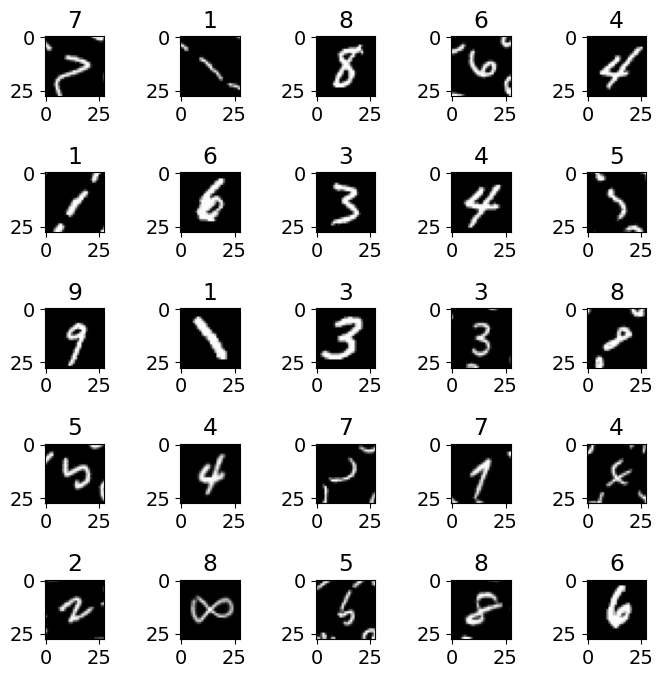

In [ ]:
example_number = 123
fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        # mnist
        axs[i,j].imshow(albumentations_dataset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        # cifar
        # axs[i,j].imshow(albumentations_dataset[example_number+i*5+j][0].reshape(32,32), cmap='gray')
        axs[i,j].set_title(albumentations_dataset[example_number+i*5+j][1])

In [ ]:
class Perceptron(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Perceptron, self).__init__()
        # fully connected layer
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        # hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class CNN(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5) 
        # 8 kernels of size 5x5
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        # 2D dropout
        self.conv2_drop = nn.Dropout2d()
        # fully connected layers
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 2 feature maps each of size 24x24
        x = F.max_pool2d(x, 2) # downsizing each map to 12x12
        x = F.relu(x) # standard (in CNNs) ReLU activation
        # 2nd group
        x = self.conv2(x) # resulting in 4 feature maps each of size 8x8
        # x = self.conv2_drop(x) 
        x = F.max_pool2d(x, 2) # downsizing each map to 4x4
        x = F.relu(x)
        # fully connected layers
        x = x.view(-1, 64) # 4 maps of 4x4 size gives 64 numbers
        x = self.fc1(x) # 64 -> 20
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # dropout is a type of regularization
        x = self.fc2(x) # 20 -> 10
        # softmax (multinomial classification) gives probabilities of each class
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch


In [ ]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss.cpu(), accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

def run_training(model,model_args,train_loader,test_loader,optimizer,validation_loader):
  train_loss = []
  validation_loss = []
  validation_accuracy = []
  test_loss = []
  test_accuracy = []
  for epoch_number in range(1, model_args['epochs'] + 1):
      train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
      val_loss, val_acc = test(model, device, validation_loader, 'Validation set')
      validation_loss.append(val_loss)
      validation_accuracy.append(val_acc)
      test_loss_, test_accuracy_ = test(model , device, test_loader, 'Test set')
      test_loss.append(test_loss_)
      test_accuracy.append(test_accuracy_)
      
  best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
  print(best_accuracy)
  return train_loss,validation_loss, best_accuracy

In [ ]:
perceptron_dict = {}
deep_dict = {}
cnn_dict = {}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(model_args['seed'])
alpha_range = list(range(0,180,10))
for alpha in alpha_range:
  print("alpha : ",alpha)
  albumentations_transform = A.SafeRotate(alpha)
  albumentations_dataset = AlbumentationsDataset(
      file_paths=images_filepaths,
      labels=images_labels,
      transform=albumentations_transform,
  )

   # # mnist
  train_subset, validation_subset = torch.utils.data.random_split(albumentations_dataset, [45000, 15000])
  test_subset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # # cifar
  # train_subset, validation_subset = torch.utils.data.random_split(albumentations_dataset, [40000, 10000])
  # test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  # subsample to speedup training (colab has notebook lifetime limit)
  train_subset = torch.utils.data.Subset(train_subset, range(20000))
  validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
  test_subset = torch.utils.data.Subset(test_subset, range(5000))


  train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
  validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
  test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)


  model_perceptron = Deep().to(device)
  optimizer = optim.SGD(model_perceptron.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
  # optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])
  perceptron_dict[alpha] = run_training(model_perceptron,model_args,train_loader,test_loader,optimizer,validation_loader)

  np.save("perceptron_dict.npy",perceptron_dict)

  model_deep = Deep().to(device)

  optimizer = optim.SGD(model_deep.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
  #optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

  deep_dict[alpha] = run_training(model_deep,model_args,train_loader,test_loader,optimizer,validation_loader)

  np.save("deep_dict.npy",deep_dict)

  model_cnn = CNN().to(device)

  optimizer = optim.SGD(model_cnn.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
  #optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

  cnn_dict[alpha] = run_training(model_cnn,model_args,train_loader,test_loader,optimizer,validation_loader)

  np.save("cnn_dict.npy",cnn_dict)

alpha :  0


100%|██████████| 9912422/9912422 [00:00<00:00, 107181242.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30784166.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24988226.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13111169.15it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.

Train Epoch: 10 [0/20000 (0%)]	Loss: 0.820111
Train Epoch: 10 [12800/20000 (64%)]	Loss: 0.834437

Train set: Average loss: 0.9074
Validation set: Average loss: 0.6289, Accuracy: 4027/5000 (81%)

Test set: Average loss: 0.2782, Accuracy: 4615/5000 (92%)

Train Epoch: 11 [0/20000 (0%)]	Loss: 0.814660
Train Epoch: 11 [12800/20000 (64%)]	Loss: 0.953138

Train set: Average loss: 0.8824
Validation set: Average loss: 0.5359, Accuracy: 4225/5000 (84%)

Test set: Average loss: 0.3084, Accuracy: 4597/5000 (92%)

Train Epoch: 12 [0/20000 (0%)]	Loss: 1.045544
Train Epoch: 12 [12800/20000 (64%)]	Loss: 0.802674

Train set: Average loss: 0.8661
Validation set: Average loss: 0.6040, Accuracy: 4041/5000 (81%)

Test set: Average loss: 0.3014, Accuracy: 4559/5000 (91%)

Train Epoch: 13 [0/20000 (0%)]	Loss: 0.874569
Train Epoch: 13 [12800/20000 (64%)]	Loss: 0.838694

Train set: Average loss: 0.8489
Validation set: Average loss: 0.5590, Accu

In [ ]:
perceptron_acc=[]
deep_acc=[]
cnn_acc=[]
# alpha_range = list(range(0,110,10))
for alpha in alpha_range:
    perceptron_acc.append(perceptron_dict[alpha][-1])
    deep_acc.append(deep_dict[alpha][-1])
    cnn_acc.append(cnn_dict[alpha][-1])
plt.plot(alpha_range, cnn_acc,label = 'cnn')
plt.plot(alpha_range, deep_acc,label = 'deep')
plt.plot(alpha_range, perceptron_acc,label = 'perceptron')
plt.xlabel('Roatation angle')
plt.ylabel('Best accuracy')
plt.legend()

KeyError: ignored